### Import modules

In [ ]:
cd

In [1]:
import datacube 
from datacube.virtual import catalog_from_file
dc = datacube.Datacube()
service = '/home/jovyan/development/'
from datacube.helpers import write_geotiff
import numpy as np
import sys

sys.path.append("../Scripts")
from dea_plotting import rgb

# product = catalog['salty']
# data = product.load(dc, **query)
# (data.vssi.squeeze()).plot.imshow()

### Locations

In [2]:
# # Adelaide:
# min_x= 550000
# max_x= 650000
# min_y= -3850000
# max_y= -3750000

# area_name: "LakeGairdner"
min_x = 350000
max_x = 400000
min_y = -3500000
max_y = -3450000

# area_name = "Lake_Eyre"
# min_x= 500000
# max_x= 600000
# min_y= -3000000
# max_y= -2900000

# # Diamantina:
# min_x= 800000
# max_x= 900000
# min_y= -2800000
# max_y= -2700000

# Gwydir:
# min_x= 1600000
# max_x= 1700000
# min_y= -3400000
# max_y= -3300000

# # Leichhardt:
# min_x= 800000
# max_x= 900000
# min_y= -2000000
# max_y= -1900000

# Tassie no data 2:
min_x= 1137670
max_x= 1185691
min_y= -4750259
max_y= -4793417


### Set parameters

In [3]:
# x = (350000, 400000)
# y = (-3500000, -3450000)

# Name
# area_name = 'Leichhardt'
x = (min_x,max_x)
y = (min_y,max_y)
res = (-100, 100)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':x,
            'y':y,
            'crs':crs,
            'resolution':res})
catalog = catalog_from_file(str(service)+'livingearth_australia/le_plugins/virtual_product_cat.yaml')

### Add le plugins

In [4]:
import importlib
import sys
import os
from datacube.virtual import DEFAULT_RESOLVER
sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))
sys.path.append(str(service)+"dea-notebooks/Scripts")
sys.path.append(str(service)+"livingearth_australia")

#see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

# Now we add the transformation we're testing
# Get location of transformation
transformation = "le_plugins.saltpan_mask"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]
DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [5]:
#see what's now in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

{'make_mask': datacube.virtual.transformations.MakeMask,
 'apply_mask': datacube.virtual.transformations.ApplyMask,
 'to_float': datacube.virtual.transformations.ToFloat,
 'rename': datacube.virtual.transformations.Rename,
 'select': datacube.virtual.transformations.Select,
 'expressions': datacube.virtual.transformations.Expressions,
 'saltpan_mask': le_plugins.saltpan_mask.saltpan_mask}

### Load data

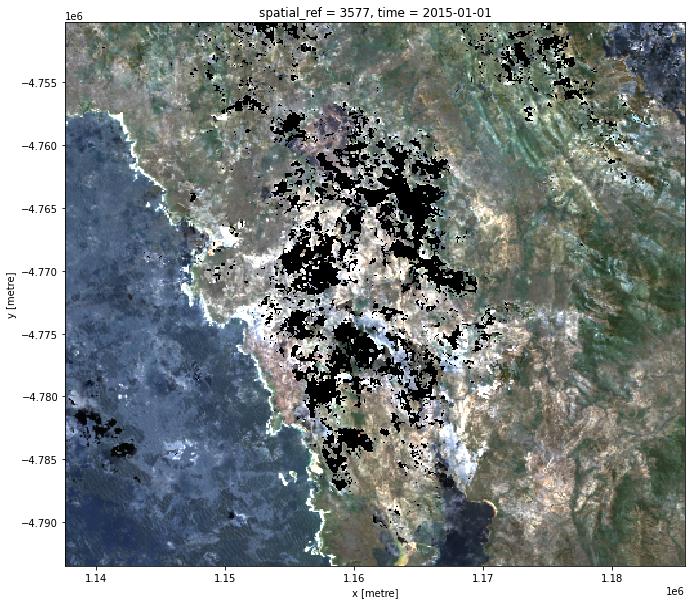

In [12]:
product = catalog['best_pixel_gm']
gm = product.load(dc, **query)
gm
# (gm.red.squeeze()).plot.imshow()

rgb(gm,bands=['red','green','blue'],size=10)

In [7]:
# plt.imshow(np.where(gm.red==np.nan,1,0)[0])
# gm.red.plot()
# plt.imshow(np.where(gm.red==0,1,0)[0])

NameError: name 'plt' is not defined

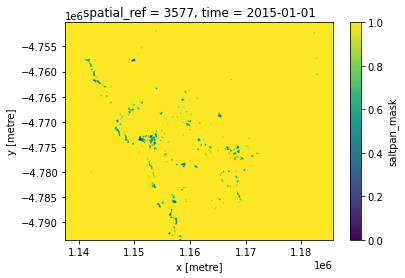

In [27]:
import matplotlib.pyplot as plt
import xarray as xr
from datacube.utils.cog import write_cog

data = gm
data['si5'] = (data['blue'] * data['red']) / (data['green'])
si5 = data.si5
si5.values = np.where(si5 < 1500, 1, 0)
si5_nan = np.where((data['red']==0), 1, si5)
si5_array = xr.DataArray(si5_nan,si5.coords,si5.dims)
squeezed = si5_array.to_dataset(name='saltpan_mask')

squeezed.isel(time=0).saltpan_mask.plot.imshow(interpolation='gaussian')

# write_cog(si5_array,'si5_nan.tif')

# squeezed = si5.squeeze(dim='time',drop=True)

In [26]:
data['si5'] = (data['blue'] * data['red']) / (data['green'])
si5 = data.si5
si5.values = np.where(si5 < 1500, 1, 0)
squeezed = si5.squeeze(dim='time',drop=True).astype('int32')

write_cog(squeezed,'si5_no_nan.tif')

PosixPath('si5_no_nan.tif')

In [22]:
pwd

'/home/jovyan/dev/dea-notebooks/Gabrielle_dev/Salt_pans'

In [ ]:
product = catalog['saltpan_mask']
salty = product.load(dc, **query)

In [ ]:
salty.saltpan_mask.plot()

### Apply salt index

Water and salt do not have similar index values, and salt is at extremes:
- SI2
- SI3
- SI4
- SI5
- SI6
- SI7
- SI10
- BI
- VSSI


In [ ]:
ds = gm

In [ ]:
# Salt index list:
ds['si1'] = ds['blue']/ds['red']
ds['si2'] = ds['blue']-(ds['red']/ds['blue'])+ds['red']
ds['si3'] = (ds['green']*ds['red'])/ds['blue']
ds['si4'] = np.sqrt(ds['red']*ds['blue'])
ds['si5'] = (ds['blue']*ds['red'])/ds['green']
ds['si6'] = (ds['red']*ds['nir'])/ds['green']
ds['si7'] = np.sqrt(ds['green']*ds['red'])
ds['si8'] = np.sqrt((ds['green']**2)*(ds['red']**2)*(ds['nir']**2))
ds['si9'] = np.sqrt((ds['green']**2)*(ds['red']**2))
ds['si10'] = (ds['nir']-ds['swir1'])/(ds['nir']+ds['swir1'])
ds['sr'] = ds['nir']/ds['red']
ds['ndsi'] = (ds['red']-ds['nir'])/(ds['red']+ds['nir'])
ds['sia'] = (ds['red']/ds['blue'])*100
ds['sit'] = (ds['red']/ds['nir'])*100
ds['bi'] = np.sqrt(ds['red']**2+ds['nir']**2)
ds['pd'] = ds['nir']/(ds['nir']+ds['red'])
ds['ipvi'] = ds['nir']/(ds['nir']+ds['red'])
ds['dvi'] = ds['nir']-ds['red']
ds['ndvi'] = (ds['nir']-ds['red'])/(ds['nir']+ds['red'])             
ds['cosri'] = ((ds['blue']+ds['green'])/(ds['red']+ds['nir']))*ds['ndvi']
ds['savi'] = 1.5*(ds['nir']+ds['red'])/(ds['nir']+ds['red']+0.5)
ds['evi'] = 2.5*((ds['nir']-ds['red'])/(ds['nir']+6*ds['red']-7.5*ds['blue']+1))
ds['gdvi'] = (ds['nir']**2-ds['red']**2)/(ds['nir']**2+ds['red']**2)
ds['msi'] = ds['swir1']/ds['nir']
ds['vssi'] =  2*ds['green']-5*(ds['red']+ds['nir'])

In [ ]:
(ds.si5.squeeze()).plot.imshow()

In [ ]:
# Keep salty areas
masked = gm.where(ds.si2>4000)
rgb(masked,bands=['red','green','blue'])

In [ ]:
rgb(gm,bands=['red','green','blue'])

In [ ]:
# Export

index_dict = ['si1','si2','si3','si4','si5','si6','si7','si8','si9','si10','sr','ndsi','sia','sit','bi','pd','ipvi','dvi','ndvi','cosri','savi','evi','gdvi','msi','vssi']
test_dict = ['si2','si3','si4','si5','si6','si7','si8','si9','si10','sit','bi','vssi']

for i in test_dict:
    dataset = ds[i].isel(time=0).to_dataset(name=i)
    write_geotiff('salt_indices/'+area_name+'_'+i+'.tif', dataset)

In [ ]:
from datacube.virtual import construct, Transformation, Measurement
import xarray as xr
import numpy as np

class saltpan_mask(Transformation):
    '''
    Use the salt index to define saltpans (as well as sandbunes and beaches) which can then be used as non-vegetated or bare surface.
    The salt index used is SI5 from Abbas and Khan (2007) 'Using Remote Sensing Techniques for Appraisal of Irrigated Soil Salinity'.
    '''
    def compute(self, data):
        # Create salt index 5 
        data['si5'] = (data['blue'] * data['red']) / (data['green'])
        si5 = data.si5
        si5.values = np.where(si5 < 1500, 1, 0)
        si5_nan = np.where((data['red']==0), np.nan, si5)
        si5_array = xr.DataArray(si5_nan,si5.coords,si5.dims)
        return si5_array.to_dataset(name='saltpan_mask')

    def measurements(self, input_measurements):
        return {'saltpan_mask': Measurement(name='saltpan_mask', dtype='float32', nodata=float('nan'), units='1')}


In [ ]:
def compute(self, data):
    # Create salt index 5 
    data['si5'] = (data['blue'] * data['red']) / (data['green'])
    si5 = data.si5
    si5.values = np.where(si5 > 1000, 1, 0)
    squeezed = si5.squeeze(dim='time',drop=True)
    return squeezed.to_dataset(name='mudflat_mask')